# Understanding Feature Mapping on Principal Components

Principal Component Analysis or PCA is a very effective technique in tackling problems related to machine learning model speed and overfitting by reducing dimensionality of data. In exploratory data analysis (EDA), PCA also heps in visualizing a two or three dimensional projection of a multi-dimensional dataset. Below is an example of 2D projection of wine dataset having 13 features. From this visualization we can get a good idea of how well separated the 3 classes are. It also helps us in understanding effect of the two principal components on the output variable. But unfortunately it doesn't throw any light on how the 13 features are contributing towards the output class separation. In this notebook we will try to overcome this limitation of PCA and establish visual relation between feature space and principal components.

For detailed understanding of PCA, you can refer the following resources.

[A One-Stop Shop for Principal Component Analysis by Matt Brems](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c)

[Feature extraction using PCA by Vincent Spruyt](https://www.visiondummy.com/2014/05/feature-extraction-using-pca/)

![](pca1.PNG)

We have chosen the same wine dataset for this study. The description of this dataset can be seen below.

In [5]:
from sklearn import datasets
wine = datasets.load_wine()
print (wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

The dataset has 3 target classes and 13 numeric features. Let's try to visualize the distribution and pairwise relation of all features.

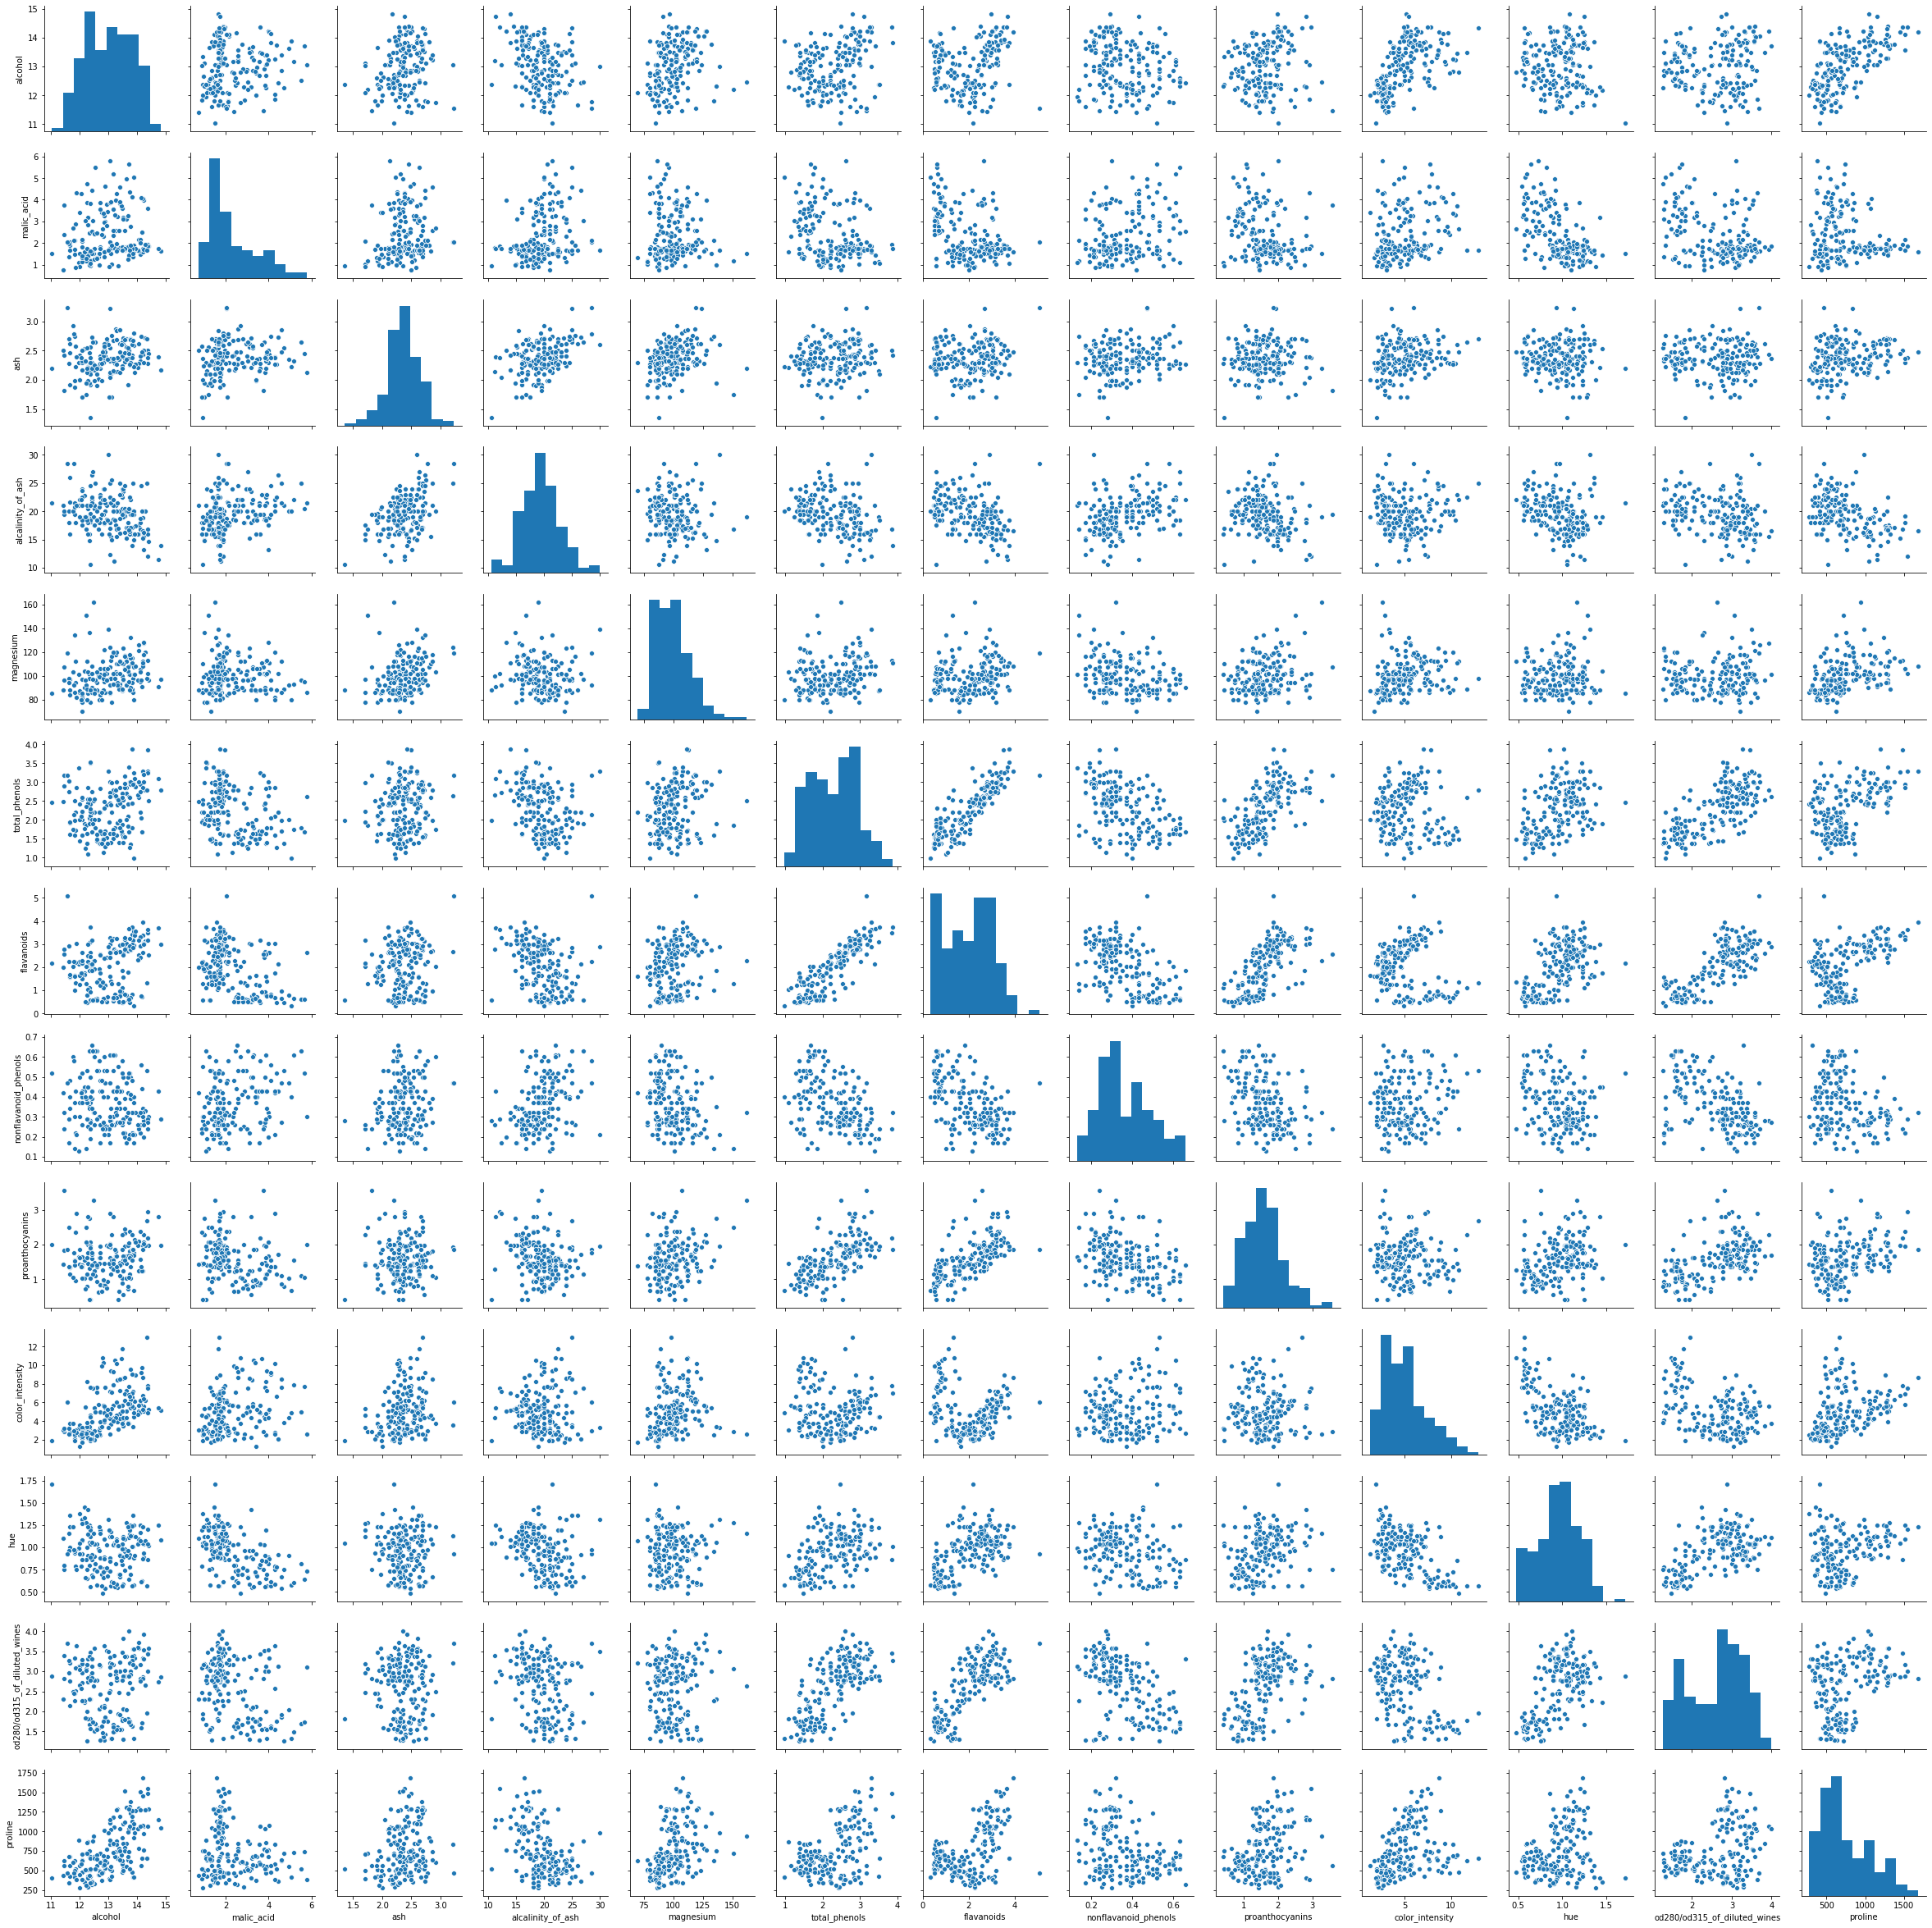

In [7]:
import pandas as pd
import seaborn as sns
features = wine.feature_names
feature_count = len(wine.feature_names)
y = wine.target
wine_df = pd.DataFrame(wine.data, columns=features)
sns.pairplot(wine_df)

From the plot we can see that features viz. 'total_phenols' and 'flavanoids' are positively correlated, whereas 'malic_acid' and 'hue' are negatively correlated. Also there are certain feature pairs viz. 'ash' and 'proanthocyanins' which are not correlated. Same observation can be validated from the correlation heatmap shown below.


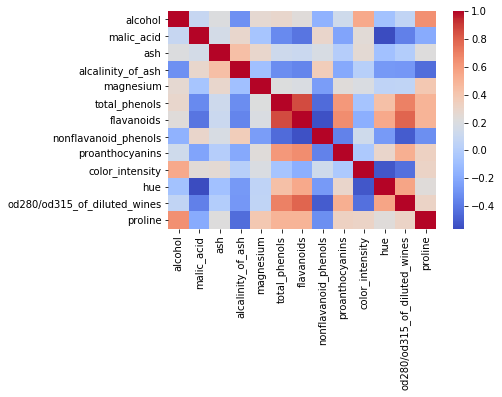

In [8]:
sns.heatmap(wine_df.corr(),cmap='coolwarm')

Now before we start building our wine classification model, it would be good to have a visual, which represents the effect of input features on output classes. But as mentioned earlier, it's difficult to represent all 13 features along with the output classes in a single plot.

One approach is to construct multiple pairwise plots each depicting the relation between one input feature and the output classes as shown below.

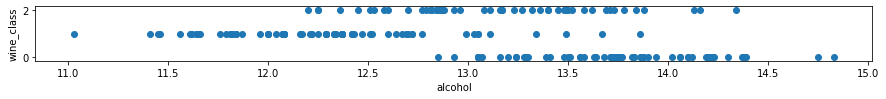

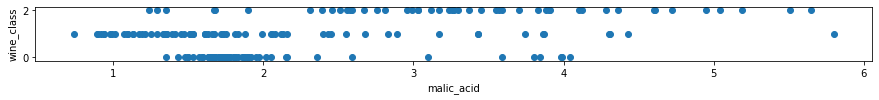

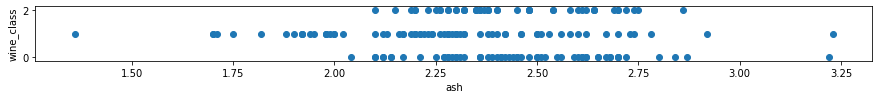

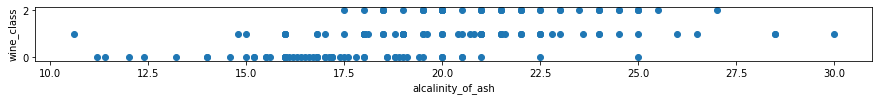

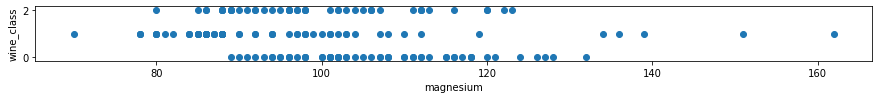

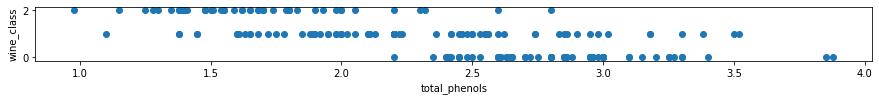

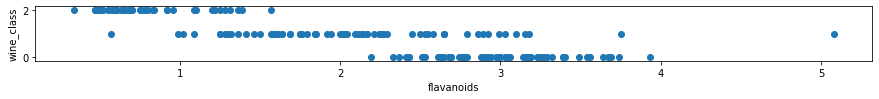

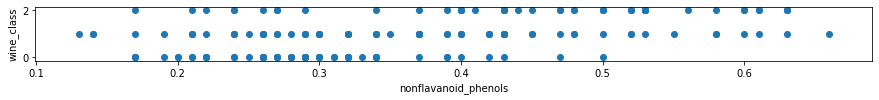

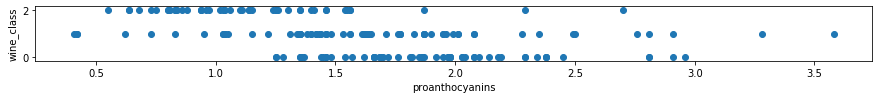

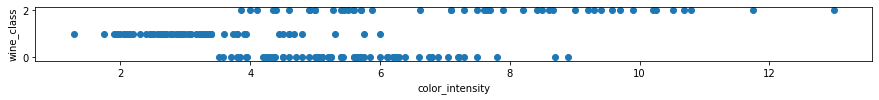

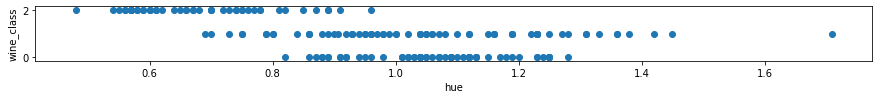

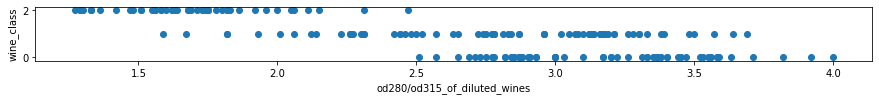

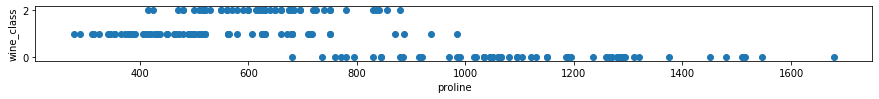

In [9]:
import matplotlib.pyplot as plt
for f in features:
    plt.figure(figsize=(15,1))
    plt.scatter(wine_df[f],y)
    plt.xlabel(f)
    plt.ylabel('wine_class')

The drawbacks of this approach are,
1. There are too many plots to investigate,
2. It's difficult to explore the multivariate nature of the problem.

To adress the above limitations, we will first try to visualize the dataset by projecting it to its first two principal components and then visualize the contribution of each individual feature along these two principal components.

So, let's start the exercise by first standardizing the data, so that all the feature columns have zero mean and 1 standard deviation. Standardization is required to ensure that the principal components are not getting biased towards any specific feature subset. Once a 2-component PCA is fitted and the standardized data is transformed using this fitted PCA model, we need to introduce feature vectors on the same PCA plane.

We can iteratively vary each individual feature keeping all other features constant and perform PCA transform for each iteration to understand the effect of that particular feature on both the principal components.
First we simulate a data where all the feature values are 0 and apply PCA transform on it. Now as the PCA was fitted on standardized data, feature value = 0, represents mean feature value and hence both the principal components of this simulated data will also be 0.

Now if we change the value of only one feature by some constant amount k and again apply PCA transform, we will observe some change in the principal component values as well. If we set a value = k for feature f, and  0 for all remaining features, that represents change of k standard deviation along feature f from mean data. The value k can be selected in such a way, so that the scaling is good for visualization when we plot the feature vectors superimposed on the actual PCA plot.

For this exercise, we have selected a value 10 for k and was able to render the following chart.

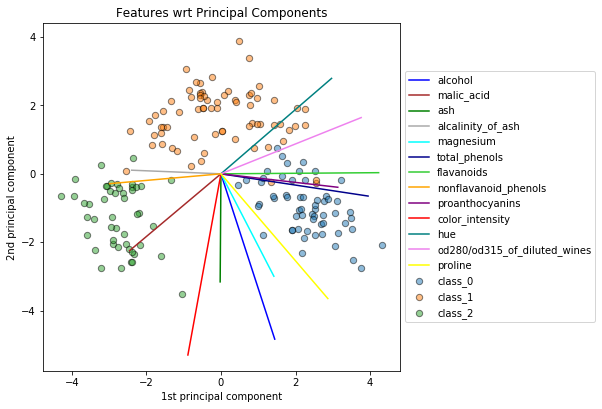

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler=StandardScaler()
scaler.fit(wine.data)
X_scaled=scaler.transform(wine.data)

pca = PCA(n_components=2).fit(X_scaled)
X_reduced = pca.transform(X_scaled)

f = np.zeros((2,feature_count))
l = X_reduced.shape[0]
colors = [ 'blue','brown', 'green', 'darkgray', 'cyan', 'darkblue', 'limegreen', 'orange', 'purple', 'red', 'teal', 'violet', 'yellow']
plt.figure(figsize=(8,6.4))
ax = plt.subplot(111)
for k in range(feature_count):
    fk = f.copy()
    fk[:,k] = [0,10]
    fk_reduced = pca.transform(fk)
    plt.plot(fk_reduced[:, 0], fk_reduced[:, 1], color = colors[k], label = features[k])
plt.title("Features wrt Principal Components")
for t in range(len(wine.target_names)):
    plt.scatter(X_reduced[:, 0][y==t], X_reduced[:, 1][y==t],edgecolor='k', s=40, alpha=0.5, label=wine.target_names[t])
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

From the above plot we can clearly see how each individual feature is affecting the principal components. The length of each feature vector represents how sensitive the principal components are towards that feature and the direction of the feature vector represent which component is getting more affected (positively or negatively) by that particular feature. Also we can obseve how correlated a pair of features are. Positively correlated features are likely to be pointing towards same direction, whereas negatively correlated features are likely to be pointing towards opposite direction. In case a pair of features are not correlated, the angle between them will tend to 90 degrees. All these observations can be validated from the correlation heatmap shown earlier.

The best part is now we can easily interpret the relation between the features and output classes. For example, features like 'flavanoids', 'total_phenols' and 'proanthocyanins' positively contribute towards 'class_0' wine, whereas 'alcalinity_of_ash' and 'nonflavanoid_phenols' have negative contribution. Not only that, if we try to increase the value of 'hue' and 'alcohol' together, that can also increase the probability of wine being classified as 'class_0', whereas increasing 'hue' alone might increase the probability of 'class_1' prediction. Similar interpretation can be made for all the wine clases as well, even before building any predictive model. 

Not convinced yet?

Try out any classification model of your choice on this dataset and find yourself whether you are able to interpret your prediction with this visualization.